**Multiple Linear Regression With Vectorization on NPU**

In [223]:
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from intel_npu_acceleration_library.backend import MatMul

In [ ]:
df = pd.read_csv("./Datasets/Sorted/possum.csv")
df = df.dropna().reset_index(drop=True)
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [225]:
X = df[df.columns[5:]]
Y = df[df.columns[4]]

split = math.floor(0.9*X.shape[0])

x = X[split:].to_numpy().astype(np.float16)
y = Y[split:].to_numpy().astype(np.float16)
X = X[:split].to_numpy().astype(np.float16)
Y = Y[:split].to_numpy().astype(np.float16)

In [226]:
inC, outC, batch = X.shape[1], 1, 1
mm = MatMul(inC, outC, batch)

In [227]:
"""f(w, b, x) = dot(w, x) + b"""
def f(w, b, x):
    ans = mm.run(w.reshape(1, 9), x.reshape(1, 9)) + b
    return np.squeeze(ans)

"""Squared Error Cost Function"""
def j(w, b, X, Y):
    cost = 0
    n =  X.shape[0]
    for i in range(n):
        cost += (f(w, b, X[i]) - Y[i])**2
    return cost/(2*n)

In [228]:
"""Gradient Calculator"""
def gradient(w, b, X, Y):
    n, m = X.shape
    dj_dw, dj_db = np.zeros(m).astype(np.float16), 0
    for i in range(n):
        err = f(w, b, X[i]) - Y[i]
        for j in range(m):
            dj_dw[j] += err*X[i, j]
        dj_db += err
    
    dj_dw /= n
    dj_db /= n

    return dj_dw, dj_db

"Gradient Descent Algorithm"
def gradient_descent(a, X, Y, epsilon=1e-6, maxiter=1000000):
    n, m = X.shape

    w, b = np.zeros(m).astype(np.float16), 0
    cost_hist = [j(w, b, X, Y),]
    for i in range(maxiter):
        dj_dw, dj_db = gradient(w, b, X, Y)

        w -= a*dj_dw
        b -= a*dj_db

        cost = j(w, b, X, Y)
        cost_hist.append(cost)
        if ((cost_hist[i] - cost_hist[i+1]) < epsilon):
            break


    return (w, b), cost_hist

In [237]:
(w, b), cost_hist = gradient_descent(1e-7, X, Y)

print(f"{w = }")
print(f"{b = }")
print(f"Cost = {j(w, b, X, Y)}")

w = array([0.007767, 0.004837, 0.00734 , 0.00311 , 0.005806, 0.003937,
       0.001299, 0.002323, 0.002842], dtype=float16)
b = 6.907385470920141e-05
Cost = 1.8286177105373806


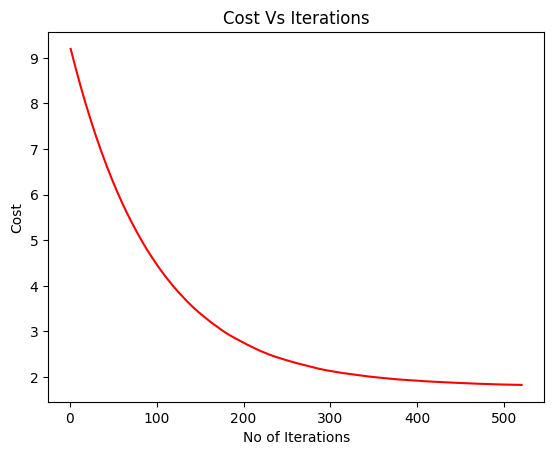

In [238]:
plt.plot(range(1, len(cost_hist)+1), cost_hist, c="r")
plt.title("Cost Vs Iterations")
plt.xlabel("No of Iterations")
plt.ylabel("Cost")
plt.show()